# Orientations points test

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [23]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.projection import project 
from src.utils import mip_x,  mip_z, create_3d_mask
from src.fsc import *
import jax

plt.rcParams["figure.figsize"]=8,8

### Some basic objects and the angles

In [31]:
N = 1000
nx = 64
ones3 = jnp.ones([nx,nx,nx])
ones2 = jnp.ones([nx,nx])
x_grid = np.array([0.05, nx])
shifts = jnp.zeros([N,3])
ctf_params = None

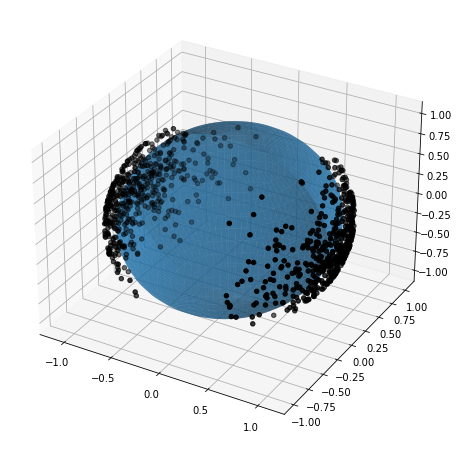

In [32]:
s = 0.3
#angles = jnp.array(np.random.rand(N,3))*jnp.pi*2
#angles_true = s*np.random.randn(int(N),3)
angles = np.concatenate([s*np.random.randn(int(N/2),3), s*np.random.randn(int(N/2),3)+np.pi], axis=0)
np.random.shuffle(angles)
angles = jnp.array(angles)

plot_angles(angles[:1000])

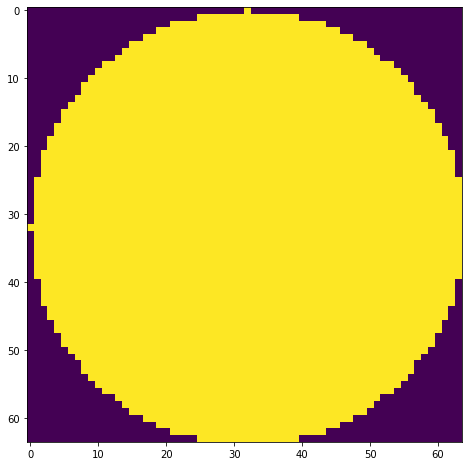

In [33]:
radius = 1.6
mask = create_3d_mask(x_grid, (0,0,0),radius)
plt.imshow(jnp.fft.fftshift(mask[:,:,0]))

### Obtain the points touched by the NN interpolation using the ajoint operator

In [5]:
# For one orientation-shifts pair
def get_nn_points_idx(ang, sh):
    slice_nn = lambda v : project(v, ang, sh, None, x_grid, x_grid, "nn")
    jac = jax.jacfwd(slice_nn)(ones3)
    c = jac.reshape(nx*nx, -1).T @ ones2.reshape(nx*nx,1)
    return c.reshape(nx,nx,nx)

In [ ]:
# And for the full angles & shifts array
points_adj = jax.vmap(get_nn_points_idx, in_axes = (0,0))(angles, shifts)
points_adj = jnp.real(jnp.sum(points_adj, axis = 0))

In [ ]:
plt.imshow(np.fft.fftshift(points_adj[:,:,0])); plt.colorbar()

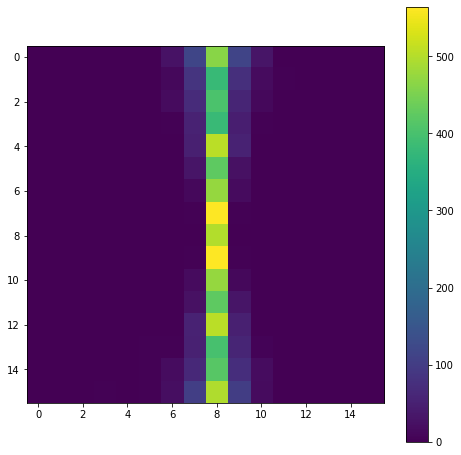

In [8]:
plt.imshow(np.fft.fftshift(points_adj[:,0,:])); plt.colorbar()

### And compare with the points generated by the the function

In [9]:
points_nn = points_orientations_nn(angles, nx)

In [10]:
assert(jnp.sum(jnp.abs(points_nn - points_adj)) == 0)

### Trilinear interpolation

In [34]:
points_tri = points_orientations_tri(angles, nx)

In [35]:
points_tri = points_tri/jnp.max(points_tri) * mask

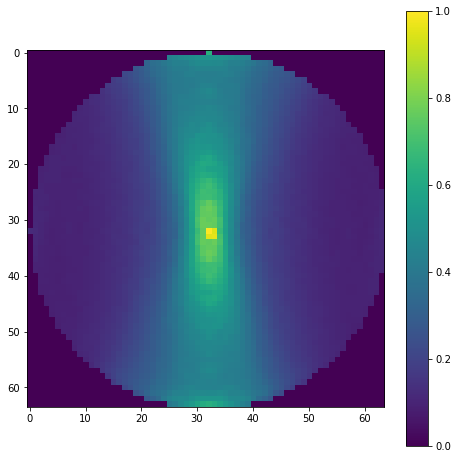

In [36]:
plt.imshow(np.fft.fftshift(points_tri[:,:,0])); plt.colorbar()

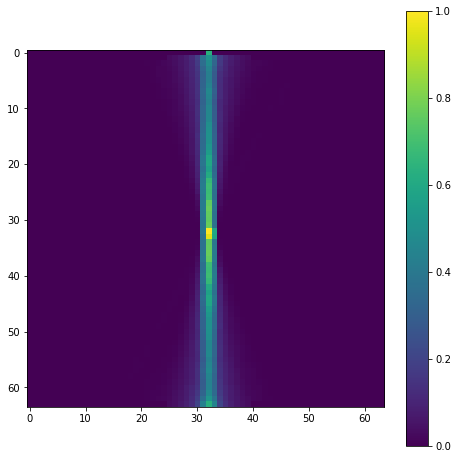

In [37]:
plt.imshow(np.fft.fftshift(points_tri[:,0,:])); plt.colorbar()

### From star file

In [86]:
%reset -f

%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.projection import project 
from src.utils import mip_x,  mip_z
from src.fsc import *
import jax

plt.rcParams["figure.figsize"]=8,8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

data_dir = "../data/"
star_file = "particles.star"

points_star = points_orientations_star(data_dir, star_file, nx = 64)

load_data: number of partcles:  4501
load_data: data loaded, time:  1.1800861358642578


In [88]:
from src.utils import create_3d_mask

nx = 64
x_grid = np.array([0.05, nx])
radius = 1.6
mask = create_3d_mask(x_grid, (0,0,0),radius)
#plt.imshow(jnp.fft.fftshift(mask[:,:,0]))

In [89]:
ps = jnp.fft.fftshift(points_star * mask)
#ps = ps/jnp.max(ps)

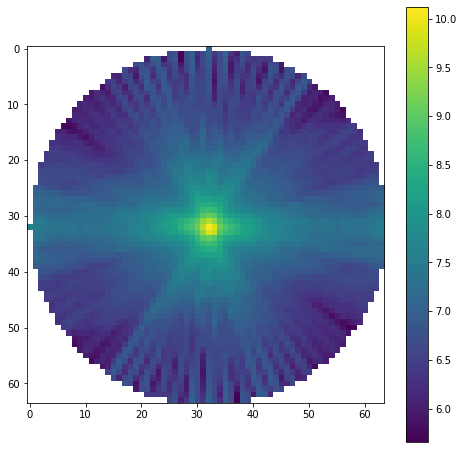

In [98]:
plt.imshow(jnp.log(ps[:,:,32])); plt.colorbar()

In [3]:
import mrcfile

In [4]:
with mrcfile.open('../data/vol2_daniel.mrcs') as f:
    v1 = f.data

In [5]:
v1.shape

(64, 64)

In [6]:
m1 = mrcfile.open('../data/vol3_daniel.mrcs')

In [7]:
m1.is_volume()

False